# Gnomix Demo

This notebook takes you through the process of using the tool for local ancestry predictions both by training a model using your own reference panel and by using a pre-trained model. It then gives an example of how one might analyze the results.

The sequencing data we'll be using is from chromosome 22 from the [1000 genomes project](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/).

In [3]:
!pip install gnomix --upgrade
!sh download_data.sh

Data downloaded and stored in gnomix/data/


When the file has been downloaded, we can split the single ancestry samples into a reference panel (training data) and a query panel (test data) for the purpose of this demo.

In [12]:
from gnomix.generate_dataset_from_1kg import generate_dataset
reference_file, reference_sample_map_path, query_file, query_sample_map_path = generate_dataset(name="demo")

Creating dataset for /home/wknd37/gnomix/data/demo
Using bcftools to create vcf with the reference samples...
Running in command line: 
	 bcftools view -S /home/wknd37/gnomix/data/demo/reference_samples.tsv -o /home/wknd37/gnomix/data/demo/reference.vcf /home/wknd37/gnomix/data/1000genomes/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
Using bcftools to create vcf with the query samples...
Running in command line: 
	 bcftools view -S /home/wknd37/gnomix/data/demo/query_samples.tsv -o /home/wknd37/gnomix/data/demo/query.vcf /home/wknd37/gnomix/data/1000genomes/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz


We can visualize it the distrubution of our ancestries

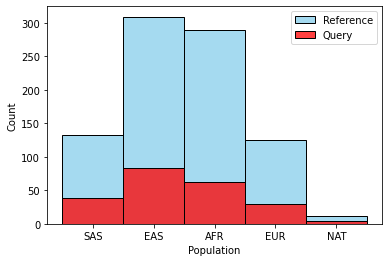

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

reference_sample_map = pd.read_csv(reference_sample_map_path, sep="\t")
query_sample_map = pd.read_csv(query_sample_map_path, sep="\t")

sns.histplot(data=reference_sample_map, x="Population", color="skyblue", label="Reference")
sns.histplot(data=query_sample_map, x="Population", color="red", label="Query")
plt.legend()
plt.show()

## Training a model from scratch and performing inference

In [ ]:
import os
from gnomix.paths import DEMO_DATA_FOLDER, GENETIC_MAP_FOLDER

output_basename = DEMO_DATA_FOLDER / "output"
output_basename.mkdir(parents=True, exist_ok=True)

should_phase = "FALSE"
CHR = "22"

train_and_inference_cmd = " ".join([
    "python3 run_gnomix.py",
    str(query_file),
    str(output_basename),
    CHR,
    should_phase,
    str(GENETIC_MAP_FOLDER / "allchrs.b37.gmap"),
    str(reference_file),
    str(reference_sample_map_path),
    f"> {output_basename}/logs.txt"
])

print("Running in command line: \n\t", train_and_inference_cmd)
status = os.system(train_and_inference_cmd)

In [ ]:
import numpy as np
from gnomix.utils import get_window_level_local_ancestry_inference_from_msp_file, get_labels_from_sample_map_file

inferred_ancestry_labels = get_window_level_local_ancestry_inference_from_msp_file(path_to_msp_file=output_basename / "query_results.msp")
true_gloabl_ancestry_labels = get_labels_from_sample_map_file(query_sample_map_path, dtype=inferred_ancestry_labels.dtype)
accuracy = np.mean(inferred_ancestry_labels == true_gloabl_ancestry_labels)*100
print(f"Accuracy: {accuracy:.2f}%")

# TODO

## Using a pre-trained model

Let's now see how one can download some of our already trained models and use them for inference.

First we'll download the models,

In [ ]:
!sh download_pretrained_models.sh

Then we run the inference on the same query file as before. This should take around 5 minutes depending on your processors. Biggest part of it is actually just loading the query file and second biggest is writing the inference to disk.

In [ ]:
path_to_model = "pretrained_gnomix_models/chr{}/model_chm_{}.pkl".format(chm, chm)

# defining and executing the command
run_cmd =  "python3 gnomix.py"
cmd = " ".join([run_cmd, query_file, output_basename, chm, phase, path_to_model]) + \
      " > ./demo/pretrained_log.txt"

print("Running in command line: \n\t", cmd)
os.system(cmd)

## Analyzing results

### Reading from the ouput

Here we read the results from the output file into a dataframe

In [ ]:
# read the output file into a dataframe
output_file = output_basename+"/query_results.msp"
msp_df = pd.read_csv(output_file, sep="\t", skiprows=[0])
msp_df

## Measuring performance

In [ ]:
from scipy import stats
from sklearn.metrics import confusion_matrix

from src.visualization import plot_cm, plot_chm

%load_ext autoreload
%autoreload 2

In [ ]:
sample_map = pd.read_csv(sample_map_file, sep="\t")

Here we predict **single ancestry** for each individual by creatoing a dataframe containing only one label prediction for each individual. We do so simply by taking the mode of the local predictions for each individual. 

In [ ]:
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)

# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]

# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})
pred_df

We can read the true labels from the sample map file and add them to the dataframe. The true ancestry labels (not only single ancestry individuals) are stored in the meta data file *demo/data/1000g.meta*.

In [ ]:
# adding the true labels
sample_map_file = "./demo/data/1000g.meta" # find the true labels in the sample map file
sample_map_df = pd.read_csv(sample_map_file, sep="\t")
true_labels_df = sample_map_df[["Sample", "Superpopulation code"]]
true_labels_df.columns = ["Sample", "Population"]
pred_df = pred_df.merge(true_labels_df)
pred_df

And then compare the predictions with the true labels

In [ ]:
# Getting the prediction accuracy
acc = np.mean(pred_df.Population == pred_df.Prediction)
print("Accuracy for single ancestry: ", acc*100, "%", sep="")

In [ ]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm, normalize=True, labels=labs)
cm_plot.figure.savefig('./demo/imgs/single_ancestry_confusion_matrix.png')

## Plotting the prediction

We can use the results to plot the predictions along the chromosome. Here is an example of how to use [Tagore](https://pypi.org/project/tagore/#usage) for that purpose. Here we visualize one individual and only for chromosome 22. See **plot_chm** from *src/visualization.py* for more details of how to to that.

In [ ]:
from IPython.display import Image

sample_id = "HG00096" # looking at just one random sample
img_name = "./demo/imgs/chm_img"
plot_chm(sample_id, msp_df, img_name=img_name)
Image(filename=img_name+".png")